In [1]:
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from tqdm.auto import tqdm
import time
import json
import os
import threading

First we collect 0.5 x 0.5 degree (approx 55 x 55 km) weather data from here: https://power.larc.nasa.gov/docs/services/api/v1/temporal/daily/

In [ ]:
params = [p.strip() for p in re.findall(
"\S+\s{3}",
"""
WS10M_MIN      MERRA2 1/2x1/2 Minimum Wind Speed at 10 Meters (m/s) 
QV2M           MERRA2 1/2x1/2 Specific Humidity at 2 Meters (g/kg) 
T2M_RANGE      MERRA2 1/2x1/2 Temperature Range at 2 Meters (C) 
WS10M          MERRA2 1/2x1/2 Wind Speed at 10 Meters (m/s) 
T2M            MERRA2 1/2x1/2 Temperature at 2 Meters (C) 
WS50M_MIN      MERRA2 1/2x1/2 Minimum Wind Speed at 50 Meters (m/s) 
T2M_MAX        MERRA2 1/2x1/2 Maximum Temperature at 2 Meters (C) 
WS50M          MERRA2 1/2x1/2 Wind Speed at 50 Meters (m/s) 
TS             MERRA2 1/2x1/2 Earth Skin Temperature (C) 
WS50M_RANGE    MERRA2 1/2x1/2 Wind Speed Range at 50 Meters (m/s) 
WS50M_MAX      MERRA2 1/2x1/2 Maximum Wind Speed at 50 Meters (m/s) 
WS10M_MAX      MERRA2 1/2x1/2 Maximum Wind Speed at 10 Meters (m/s) 
WS10M_RANGE    MERRA2 1/2x1/2 Wind Speed Range at 10 Meters (m/s) 
PS             MERRA2 1/2x1/2 Surface Pressure (kPa) 
T2MDEW         MERRA2 1/2x1/2 Dew/Frost Point at 2 Meters (C) 
T2M_MIN        MERRA2 1/2x1/2 Minimum Temperature at 2 Meters (C) 
T2MWET         MERRA2 1/2x1/2 Wet Bulb Temperature at 2 Meters (C) 
PRECTOT        MERRA2 1/2x1/2 Precipitation (mm day-1) 
"""
)]

In [37]:
response = requests.get(
    'https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py',
    {
        'request': 'execute',
        'tempAverage': 'DAILY',
        'identifier': 'SinglePoint',
        'parameters': ','.join(params),
        'userCommunity': 'SB',
        'lon': 0,
        'lat': 0,
        'startDate': 20000101,
        'endDate': 20201231,
        'outputList': 'JSON',
    }
)

In [38]:
data = response.json()

In [41]:
response.json()['features'][0]['properties']['parameter'].keys()

dict_keys(['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE'])

Get county lat/lon locations from here: https://en.wikipedia.org/wiki/User:Michael_J/County_table

In [49]:

df = pd.read_html('https://en.wikipedia.org/wiki/User:Michael_J/County_table', index_col=0)[0]

In [50]:
df.head()

,State,FIPS,County [2],County Seat(s) [3],Population(2010),Land Areakm²,Land Areami²,Water Areakm²,Water Areami²,Total Areakm²,Total Areami²,Latitude,Longitude
Sort [1],,,,,,,,,,,,,
1,AL,1001,Autauga,Prattville,54571,1539.582,594.436,25.776,9.952,1565.358,604.388,+32.536382°,–86.644490°
2,AL,1003,Baldwin,Bay Minette,182265,4117.522,1589.784,1133.190,437.527,5250.712,2027.311,+30.659218°,–87.746067°
3,AL,1005,Barbour,Clayton,27457,2291.819,884.876,50.865,19.639,2342.684,904.515,+31.870670°,–85.405456°
4,AL,1007,Bibb,Centreville,22915,1612.481,622.582,9.289,3.587,1621.770,626.169,+33.015893°,–87.127148°
5,AL,1009,Blount,Oneonta,57322,1669.962,644.776,15.157,5.852,1685.119,650.628,+33.977448°,–86.567246°


In [51]:
float_degrees = lambda x: float(x.replace('°','').replace('–','-'))
df['Latitude'] = df['Latitude'].apply(float_degrees)
df['Longitude'] = df['Longitude'].apply(float_degrees)

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

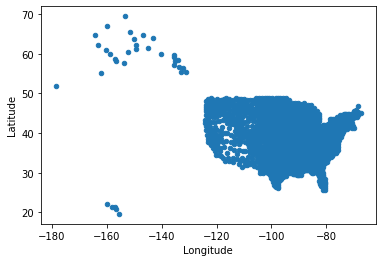

In [56]:
df.plot(x='Longitude', y='Latitude', kind='scatter')

Let's remove values outside the mainland to make our lifes easier.

In [57]:
df = df[df['Longitude']>-130]

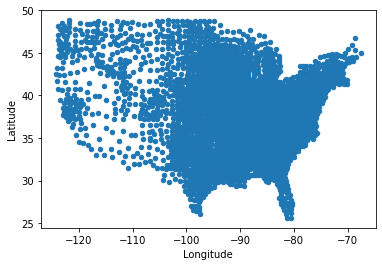

In [77]:
ax = df.plot(x='Longitude', y='Latitude', kind='scatter')

There are a lot fewer counties in the west than east, we will have to live with that for now.

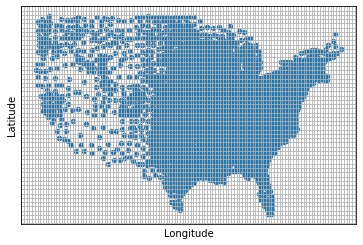

In [78]:
ax = df.plot(x='Longitude', y='Latitude', kind='scatter')
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelleft=False,
    labelbottom=False
)
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=.5))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=.5))
plt.grid()

Above shows the .5 x .5 grid of available weather data.

In [84]:
df['Land Areakm²'].mean()**.5

49.61415926865706

In [157]:
def get_weather(fips):
    fips_county = df[df['FIPS']==fips]
    lat, lon = fips_county['Latitude'].values[0], fips_county['Longitude'].values[0]
    return requests.get(
        'https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py',
        {
            'request': 'execute',
            'tempAverage': 'DAILY',
            'identifier': 'SinglePoint',
            'parameters': ','.join(params),
            'userCommunity': 'SB',
            'lon': lon,
            'lat': lat,
            'startDate': 20000101,
            'endDate': 20201231,
            'outputList': 'JSON',
        }
    ).json()['features'][0]['properties']['parameter']

In [158]:
get_weather(df['FIPS'].sample().values[0])

{'PRECTOT': {'20000101': 0.02,
  '20000102': 0.61,
  '20000103': 3.72,
  '20000104': 7.95,
  '20000105': 0.05,
  '20000106': 0.0,
  '20000107': 0.11,
  '20000108': 0.01,
  '20000109': 0.79,
  '20000110': 16.64,
  '20000111': 0.81,
  '20000112': 0.06,
  '20000113': 3.37,
  '20000114': 0.09,
  '20000115': 0.02,
  '20000116': 0.07,
  '20000117': 0.01,
  '20000118': 0.17,
  '20000119': 0.25,
  '20000120': 7.29,
  '20000121': 0.07,
  '20000122': 0.03,
  '20000123': 0.12,
  '20000124': 0.01,
  '20000125': 6.64,
  '20000126': 1.22,
  '20000127': 0.11,
  '20000128': 0.01,
  '20000129': 0.02,
  '20000130': 9.95,
  '20000131': 1.06,
  '20000201': 0.17,
  '20000202': 0.02,
  '20000203': 1.12,
  '20000204': 0.75,
  '20000205': 0.1,
  '20000206': 0.03,
  '20000207': 0.03,
  '20000208': 0.0,
  '20000209': 0.05,
  '20000210': 0.1,
  '20000211': 1.14,
  '20000212': 0.14,
  '20000213': 4.32,
  '20000214': 19.75,
  '20000215': 0.01,
  '20000216': 0.24,
  '20000217': 0.02,
  '20000218': 10.5,
  '20000219

The average county is a bit smaller than the 0.5 x 0.5 degree square, so we will not alter the weather data for now.

Let's now get drought values from https://droughtmonitor.unl.edu/WebServiceInfo.aspx#comp

In [148]:
def get_drought(fips):
    return requests.get(
        'https://usdmdataservices.unl.edu/api/CountyStatistics/GetDroughtSeverityStatisticsByAreaPercent',
        {
            'aoi': fips,
            'startdate': '1/1/2000',
            'enddate': '12/31/2020',
            'statisticsType': 1,
        }
    ).json()

In [149]:
get_drought(df['FIPS'].sample().values[0])

[{'MapDate': '20201229',
  'FIPS': '46117',
  'County': 'Stanley County',
  'State': 'SD',
  'None': '0.00',
  'D0': '100.00',
  'D1': '63.42',
  'D2': '0.00',
  'D3': '0.00',
  'D4': '0.00',
  'ValidStart': '2020-12-29',
  'ValidEnd': '2021-01-04',
  'StatisticFormatID': '1'},
 {'MapDate': '20201222',
  'FIPS': '46117',
  'County': 'Stanley County',
  'State': 'SD',
  'None': '0.00',
  'D0': '100.00',
  'D1': '63.42',
  'D2': '0.00',
  'D3': '0.00',
  'D4': '0.00',
  'ValidStart': '2020-12-22',
  'ValidEnd': '2020-12-28',
  'StatisticFormatID': '1'},
 {'MapDate': '20201215',
  'FIPS': '46117',
  'County': 'Stanley County',
  'State': 'SD',
  'None': '0.00',
  'D0': '100.00',
  'D1': '63.42',
  'D2': '0.00',
  'D3': '0.00',
  'D4': '0.00',
  'ValidStart': '2020-12-15',
  'ValidEnd': '2020-12-21',
  'StatisticFormatID': '1'},
 {'MapDate': '20201208',
  'FIPS': '46117',
  'County': 'Stanley County',
  'State': 'SD',
  'None': '0.00',
  'D0': '100.00',
  'D1': '63.42',
  'D2': '0.00',
  '

In [174]:
def scrape_drought():
    for i, row in tqdm(df.iterrows(), total=len(df)):
        fips = row['FIPS']
        if len(str(fips)) == 4:
            str_fips = "0" + str(fips)
        else:
            str_fips = str(fips)
        if not os.path.isfile(f'data/{fips}_drought.json'):
            with open(f'data/{fips}_drought.json', 'w') as outfile:
                json.dump(get_drought(str_fips), outfile)
                
def scrape_weather():
    for i, row in tqdm(df.iterrows(), total=len(df)):
        fips = row['FIPS']
        if not os.path.isfile(f'data/{fips}_weather.json'):
            with open(f'data/{fips}_weather.json', 'w') as outfile:
                json.dump(get_weather(fips), outfile)

In [177]:
drought_thread = threading.Thread(target=scrape_drought)
drought_thread.start()

In [178]:
weather_thread = threading.Thread(target=scrape_weather)
weather_thread.start()

In [179]:
df.to_pickle('counties.pkl')

In [181]:
from urllib.parse import urlencode